In [ ]:
## 9주차 과제_0502(금)

파이썬 머신러닝 완벽가이드 개정2판 ch9. 7~9 p.625~647

## 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

행렬 분해 잠재 요인 협업 필터링

SVD, NMF 적용 가능

일반적으로 행렬 분해에는 SVD가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 Null 데이터가 많기 때문에 주로 SGD나 ALS 기반의 행렬 분해 이용

In [ ]:
# SGD 기반 행렬 분해 구현
# 확률적 경사 하강법을 이용한 행렬 분해 예제의 get_rmse() 함수 사용
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q,non_zeros):
    error=0
    # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [ ]:
# 행렬 분해 로직 함수 정의
def matrix_factorization(R, K, steps = 200, learning_rate = 0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤한 값으로 입력
    np.random.seed(1)
    P = np.random.normal(scale = 1./K, size = (num_users, K))
    Q = np.random.normal(scale = 1./K, size = (num_items, K))

    # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
    non_zeros = [(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0]

    # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i,:], Q[j,:].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda * P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda * Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0:
            print('### iteration step :', step, 'rmse :', rmse)

    return P, Q

In [ ]:
# 영화 평정 행렬 데이터를 데이터프레임으로 로딩한 후 다시 사용자-아이템 평점 행렬로 변경
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
rating_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on = 'movieId')

# columns = 'title'로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns = 'title')

In [ ]:
# 사용자-아이템 평점 행렬을 행렬 분해 진행
P, Q = matrix_factorization(ratings_matrix.values, K = 50, steps = 200, learning_rate = 0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step : 0 rmse : 2.9023619751336867
### iteration step : 10 rmse : 0.7335768591017927
### iteration step : 20 rmse : 0.5115539026853442
### iteration step : 30 rmse : 0.37261628282537446
### iteration step : 40 rmse : 0.2960818299181014
### iteration step : 50 rmse : 0.2520353192341642
### iteration step : 60 rmse : 0.22487503275269854
### iteration step : 70 rmse : 0.2068545530233154
### iteration step : 80 rmse : 0.19413418783028685
### iteration step : 90 rmse : 0.18470082002720406
### iteration step : 100 rmse : 0.17742927527209104
### iteration step : 110 rmse : 0.1716522696470749
### iteration step : 120 rmse : 0.16695181946871726
### iteration step : 130 rmse : 0.16305292191997542
### iteration step : 140 rmse : 0.15976691929679646
### iteration step : 150 rmse : 0.1569598699945732
### iteration step : 160 rmse : 0.15453398186715425
### iteration step : 170 rmse : 0.15241618551077643
### iteration step : 180 rmse : 0.1505508073962831
### iteration step : 190 rmse : 

In [ ]:
# 예측 사용자-아이템 평점 행렬을 영화 타이틀 칼럼명으로 가지는 데이터프레임으로 변환
rating_pred_matrix = pd.DataFrame(data = pred_matrix, index = rating_matrix.index, columns = ratings_matrix.columns)
rating_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [ ]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
    # 반환된 user_rating은 영화명(title)을 인덱스를 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId, :]

    #user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듦.
    movies_list = ratings_matrix.columns.tolist()

    # list comporehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [ ]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(rating_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index, columns = ['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


## 파이썬 추천 시스템 패키지 - Surprise

### Surprise 패키지 소개

Surprise : 파이썬 기반에서 사이킷런과 유사한 API와 프레임워크 제공

주요 장점

- 다양한 추천 알고리즘, 예를 들어 사용자 또는 아이템 기반 최근접 이웃 협얼 필터링, SVD, SVD++, NMF 기반의 잠재 요인 협업 필터링을 쉽게 적용해 추천 시스템 구축 가능

- Surprise의 핵심 API는 사이킷런의 핵심 API와 유사한 API명으로 작성됨. 예를 들어 fit(), predict() API로 추천 데이터 학습과 예측, train_test_split()으로 추천 학습 데이터 세트와 예측 데이터 세트 분리, cross_calidate(), GridSearchCV 클래스를 통해 추천 시스템을 위한 모델 셀렉션 평가, 하이퍼 파라미터 튜닝 등의 기능 제공

### Surprise를 이용한 추천 시스템 구축

In [2]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505221 sha256=dc4a0fb96e7f64822ce47e32fca22889a13d4e12d94db47c0f92f60b2035fe4a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [3]:
# SVD로 잠재 요인 협업 필터링 수행
algo = SVD(random_state = 0)
algo.fit(trainset)

In [6]:
# 학습된 추천 알고리즘을 기반으로 test() 메서드를 이용해 테스트 데이터에 대해 추천
predictions = algo.test(testset)
print('prediction type :', type(predictions), 'size : ', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'> size :  25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [7]:
# prediction 객체에서 uid, iid, est 속성 추출
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [8]:
# predict()를 이용해 추천 예측
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


predict()는 개별 사용자와 아이템 정보를 입력하면 추천 예측 평점을 est로 반환해줌

test() 메서드는 입력 데이터 세트의 모든 사용자와 아이템 아이디에 대해서 predict()를 반복적으로 수행한 결과임

In [9]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

### Surprise 주요 모듈 소개

**Dataset**

Surprise는 user_id, item_id, rating 데이터가 로우 레벨로 된 데이터 세트만 적용 가능

데이터의 첫 번쨰 칼럼을 사용자 아이디, 두 번째 칼럼을 아이템 아이디, 세 번째 칼럼을 평점으로 가정해 데이터를 로딩하고 네 번째 칼럼부터는 아예 로딩을 수행하지 않음

#### OS 파일 데이터를 Surprise 데이터 세트로 로딩

Surprise에 OS 파일을 로딩할 때 로딩 되는 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안됨

In [11]:
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings.csv')
# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings_noh.csv', index = False, header = False)

In [13]:
# line_format 인자로 user, item, rating, timestamp 4개의 칼럼으로 데이터 구성되있음을 명시
# 로딩 시 앞의 3개 칼럼만 로딩되고 timestamp 칼럼은 제외됨
from surprise import Reader

reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5))
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings_noh.csv', reader = reader)

surprise 데이터 세트는 기본적으로 무비렌즈 데이터 형식을 따르므로 무비렌즈 데이터 형식이 아닌 다른 OS 파일의 경우 Reader 클래스를 먼저 설정해야 함

**Reader 클래스의 주요 생성 파라미터**

- line_format(string) : 칼럼을 순서대로 나열, 입력된 문자열을 공백으로 분리해 칼럼으로 인식

- sep(char) : 칼럼을 분리하는 분리자이며 디폴트는 '\t', 판다스 DataFrame에서 입력받을 경우에는 기재할 필요 없음

- rating_scale(tuple, optional) : 평점 값의 최소 ~ 최대 평점 설정, 디폴트는 (1, 5)

In [15]:
# SVD 행렬 분해 기법을 이용해 추천 예측
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors = 50, random_state = 0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

#### 판다스 DataFrame에서 Surprise 데이터 세트로 로딩

In [17]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings.csv')
reader = Reader(rating_scale = (0.5, 5))

# ratings DataFrame에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 0)

algo = SVD(n_factors = 50, random_state = 0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

### Surprise 추천 알고리즘 클래스

SVD : 행렬 분해를 통한 잠재 요인 협업 필터링을 위한 SVD 알고리즘

KNNBasic : 최근접 이웃 협업 필터링을 위한 KNN 알고리즘

BaselineOnly : 사용자 Bias와 아이템 Bias를 감안한 SGD 베이스라인 알고리즘

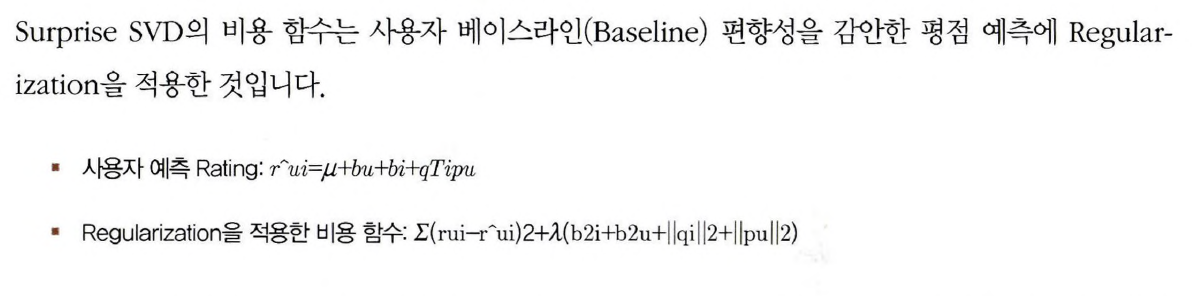

**SVD 클래스 입력 파라미터**

n_factors : 잠재 요인 K의 개수, 디폴트는 100, 커질수록 정확도가 높아질 수 있으나 과적합 문제 발생

n_epochs : SGD 수행 시 반복 횟수, 디폴트는 20

biased(bool) : 베이스라인 사용자 편향 적용 여부, 디폴트는 True

### 베이스라인 평점

베이스라인 평점(Baseline Rating) : 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것

베이스라인 평점 = 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수

- 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값

- 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점

- 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

### 교차 검증과 하이퍼 파라미터 튜닝

In [18]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings.csv')
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state = 0)
cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8695  0.8720  0.8737  0.8780  0.8694  0.8725  0.0032  
MAE (testset)     0.6673  0.6703  0.6721  0.6732  0.6690  0.6704  0.0021  
Fit time          2.35    2.30    1.54    1.59    1.55    1.87    0.38    
Test time         0.20    0.28    0.12    0.29    0.13    0.20    0.07    


{'test_rmse': array([0.86951059, 0.87201629, 0.87371975, 0.87804567, 0.86937016]),
 'test_mae': array([0.66726087, 0.67034653, 0.67213628, 0.67324492, 0.66899407]),
 'fit_time': (2.3543691635131836,
  2.2952537536621094,
  1.535351037979126,
  1.5910022258758545,
  1.5526862144470215),
 'test_time': (0.19871973991394043,
  0.28138041496276855,
  0.11694192886352539,
  0.2897915840148926,
  0.12517738342285156)}

In [19]:
# CV가 3일 떄 최적 하이퍼 파라미터 도출하기
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_gird = {'n_epochs' : [20, 40, 60], 'n_factors' : [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_gird, measures = ['rmse', 'mse'], cv = 3)
gs.fit(data)

# 최고 RMSE Evalutaions 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8772356944982086
{'n_epochs': 20, 'n_factors': 50}


### Surprise를 이용한 개인화 영화 추천 시스템 구축

In [20]:
# 다음 코드는 trian_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류가 발생함
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors = 50, random_state = 0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [23]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format = 'user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file = '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/ratings_noh.csv', reader= reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [24]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [26]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/ml-latest-small/movies.csv')

# userId = 9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds == 42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [27]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [28]:
# 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤 예측 평점 순으로 영화 추천
def get_unseen_surprise(ratings, movies, userId):
    # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

    # 모든 영화의 movieid를 리스트로 생성
    total_movies = movies['movieId'].tolist()

    # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [29]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est

    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]

    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
